### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read slimmed PKU Tree files
2. Store the raw MC histograms to pickle files

kernel:HWW



### Import necessary modules

In [1]:
import numpy as np
import os
# import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
# from scipy import interpolate
# from sklearn.metrics import roc_curve, auc
from cycler import cycler
import uproot
# means uproot4
# import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings

import hist as hist2
import pyarrow
# import utils #local file: utils.py
import yaml
from typing import Dict, List, Union
from dataclasses import dataclass, field
from copy import deepcopy

# from coffea import hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector
# from coffea.nanoevents.methods.vector import PtEtaPhiMLorentzVector

In [2]:
YEAR = "2018"

### Define templates dir

In [3]:
MAIN_DIR = "."

plot_dir = f"{MAIN_DIR}/templates/6May2024_JES_split"
_ = os.system(f"mkdir -p {plot_dir}")

### Read SlimmedTree files

In [4]:
#load the slimmedtree files using uproot

#different year available here.
# year = "2016APV"
# year = "2016"
# year = "2017"
# year = "2018"
# year = "Full-Run2"
year = YEAR

#if run on PKU cluster, use this:
# CustNanoData = {
#     'data'        : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Data/SlimmedTree_Data.root"%(year),
#     'QCD'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/MC/SlimmedTree_QCD.root"%(year),
#     'Top'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/MC/SlimmedTree_Top.root"%(year),
#     'WJets'       : "/data/bond/zhaoyz/SlimmedTree/V5/%s/MC/SlimmedTree_WJets.root"%(year),
#     'Rest'        : "/data/bond/zhaoyz/SlimmedTree/V5/%s/MC/SlimmedTree_Rest.root"%(year),
#     'TotalSignal' : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_Total.root"%(year),
#     'ggF'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_GluGlu.root"%(year),
#     'VH'          : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_VH.root"%(year),
#     'ttH'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_ttH.root"%(year),
#     'VBF'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_VBF.root"%(year),
# } 

#if run on lxplus, use this:
# CustNanoData = {
#     'data'        : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/Data/SlimmedTree_Data.root"%(year),
#     'QCD'         : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/MC/SlimmedTree_QCD.root"%(year),
#     'Top'         : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/MC/SlimmedTree_Top.root"%(year),
#     'WJets'       : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/MC/SlimmedTree_WJets.root"%(year),
#     'Rest'        : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/MC/SlimmedTree_Rest.root"%(year),
#     'TotalSignal' : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/Signal/SlimmedTree_Total.root"%(year),
#     'ggF'         : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/Signal/SlimmedTree_GluGlu.root"%(year),
#     'VH'          : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/Signal/SlimmedTree_VH.root"%(year),
#     'ttH'         : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/Signal/SlimmedTree_ttH.root"%(year),
#     'VBF'         : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/Signal/SlimmedTree_VBF.root"%(year),
# }  

#if run on CMSconnect, use this:
CustNanoData = {
    'data'        : "/ospool/cms-user/yuzhe/SlimmedTree/V7/%s/Data/SlimmedTree_Data.root"%(year),
    'QCD'         : "/ospool/cms-user/yuzhe/SlimmedTree/V7/%s/MC/SlimmedTree_QCD.root"%(year),
    'TT'          : "/ospool/cms-user/yuzhe/SlimmedTree/V7/%s/MC/SlimmedTree_TT.root"%(year),
    'ST'          : "/ospool/cms-user/yuzhe/SlimmedTree/V7/%s/MC/SlimmedTree_ST.root"%(year),
    'WJets'       : "/ospool/cms-user/yuzhe/SlimmedTree/V7/%s/MC/SlimmedTree_WJets.root"%(year),
    'Rest'        : "/ospool/cms-user/yuzhe/SlimmedTree/V7/%s/MC/SlimmedTree_Rest.root"%(year),
    'TotalSignal' : "/ospool/cms-user/yuzhe/SlimmedTree/V7/%s/Signal/SlimmedTree_Total.root"%(year),
    'ggF'         : "/ospool/cms-user/yuzhe/SlimmedTree/V7/%s/Signal/SlimmedTree_GluGlu.root"%(year),
    'ZH'          : "/ospool/cms-user/yuzhe/SlimmedTree/V7/%s/Signal/SlimmedTree_WH.root"%(year),
    'WH'          : "/ospool/cms-user/yuzhe/SlimmedTree/V7/%s/Signal/SlimmedTree_HZJ.root"%(year),
    'ttH'         : "/ospool/cms-user/yuzhe/SlimmedTree/V7/%s/Signal/SlimmedTree_ttH.root"%(year),
    'VBF'         : "/ospool/cms-user/yuzhe/SlimmedTree/V7/%s/Signal/SlimmedTree_VBF.root"%(year),
}        

files = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" })

### Get DPhi in the events

In [5]:
def get_dphi(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    delta_phi = np.subtract(vec_MET.phi, vec_higgs.phi)
    delta_phi = np.where(delta_phi > np.pi, delta_phi - 2*np.pi, delta_phi)
    delta_phi = np.where(delta_phi < -np.pi, delta_phi + 2*np.pi, delta_phi)
    delta_phi = np.abs(delta_phi)
    print(delta_phi)
    events["DPhi"] = delta_phi

In [6]:
for k in files:
    print("Add dphi of:",k)
    get_dphi(events=files[k])

Add dphi of: data
[0.719, 0.16, 2.82, 0.0338, 2.16, 2.61, ... 0.767, 0.2, 0.504, 3.03, 0.289, 0.0353]
Add dphi of: QCD
[3.07, 0.27, 2.35, 2.65, 3.1, 3.14, 2.42, ... 0.0396, 3.07, 0.765, 3, 2.96, 3.07]
Add dphi of: TT
[0.995, 0.922, 3.01, 2.3, 0.567, 2.13, ... 0.0696, 0.482, 2.33, 1.1, 2.82, 0.655]
Add dphi of: ST
[0.844, 2.22, 2.18, 0.272, 0.142, 0.399, ... 0.434, 0.149, 2.47, 0.413, 0.933, 0.12]
Add dphi of: WJets
[1.91, 2.47, 3.11, 3.03, 1.31, 1.97, 2.59, ... 0.218, 2.77, 2.3, 0.932, 0.259, 0.018]
Add dphi of: Rest
[2.74, 0.925, 2.72, 2.18, 3.13, 0.0352, ... 0.399, 2.72, 1.77, 0.0236, 0.116, 0.534]
Add dphi of: TotalSignal
[2.66, 1.61, 1.12, 0.109, 1.49, 1.81, 2.33, ... 1.29, 2.82, 2.8, 2.35, 0.21, 0.229]
Add dphi of: ggF
[2.66, 1.61, 1.12, 0.109, 1.49, 1.81, ... 0.165, 0.383, 2.83, 0.49, 2.48, 0.814]
Add dphi of: ZH
[0.114, 2.23, 0.0938, 0.496, 2.27, 0.0228, ... 2.3, 0.0768, 1.29, 3.06, 0.297, 0.293]
Add dphi of: WH
[0.00014, 1.91, 0.769, 1.97, 3.12, 0.323, ... 0.762, 0.51, 0.458, 2

### Get MET recovery mass

In [7]:

def get_reco(events,mass = "Mj_corr_V2_a", MET_UE = None):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events[mass]
    if not MET_UE:
        pT_MET = events["MET_et"]
        phi_MET = events["MET_phi"]
    elif MET_UE == "up":
        pT_MET = events["MET_et_UEup"]
        phi_MET = events["MET_phi_UEup"]
    elif MET_UE == "down":
        pT_MET = events["MET_et_UEdown"]
        phi_MET = events["MET_phi_UEdown"]
    eta_MET = events["Etaj_V2_a"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_sum = vec_MET + vec_higgs
    mH_reco = vec_sum.mass
    if not MET_UE: mass_str = "MH_Reco" if mass == "Mj_corr_V2_a" or mass == "Mj_V2_a" else mass
    else : mass_str = "MH_Reco" + "_UE_" + MET_UE
    
    if not MET_UE: 
        events[mass_str] = ak.where(( (events["DPhi"] < 0.8) & (events["MET_et"]/events["PTj_V2_a"] > 0.1)), mH_reco, events[mass])
    elif MET_UE == "up" : 
        events[mass_str] = ak.where(( (events["DPhi"] < 0.8) & (events["MET_et_UEup"]/events["PTj_V2_a"] > 0.1)), mH_reco, events[mass])
    elif MET_UE == "down" : 
        events[mass_str] = ak.where(( (events["DPhi"] < 0.8) & (events["MET_et_UEdown"]/events["PTj_V2_a"] > 0.1)), mH_reco, events[mass])

In [8]:
for k in files:
    # note that QCD and Data don't have such variation
    if k == "data" or k == "QCD": continue
    print("Add reco of:",k)
    get_reco(events=files[k])
    get_reco(events=files[k],MET_UE = "up")
    get_reco(events=files[k],MET_UE = "down")
    
    get_reco(events=files[k],mass = "Mj_jesTotalUp_a")
    get_reco(events=files[k],mass = "Mj_jesTotalDown_a")
    get_reco(events=files[k],mass = "Mj_jerUp_a")
    get_reco(events=files[k],mass = "Mj_jerDown_a")
    
    get_reco(events=files[k],mass = "Mj_jmsUp_a")
    get_reco(events=files[k],mass = "Mj_jmsDown_a")
    get_reco(events=files[k],mass = "Mj_jmrUp_a")
    get_reco(events=files[k],mass = "Mj_jmrDown_a")
    
    #split JES
    get_reco(events=files[k],mass = "Mj_jesAbsoluteUp_a")
    get_reco(events=files[k],mass = "Mj_jesAbsoluteDown_a")
    get_reco(events=files[k],mass = "Mj_jesAbsolute_yearUp_a")
    get_reco(events=files[k],mass = "Mj_jesAbsolute_yearDown_a")
    get_reco(events=files[k],mass = "Mj_jesBBEC1Down_a")
    get_reco(events=files[k],mass = "Mj_jesBBEC1Up_a")
    get_reco(events=files[k],mass = "Mj_jesBBEC1_yearUp_a")
    get_reco(events=files[k],mass = "Mj_jesBBEC1_yearDown_a")
    get_reco(events=files[k],mass = "Mj_jesEC2Up_a")
    get_reco(events=files[k],mass = "Mj_jesEC2Down_a")
    get_reco(events=files[k],mass = "Mj_jesEC2_yearUp_a")
    get_reco(events=files[k],mass = "Mj_jesEC2_yearDown_a")
    get_reco(events=files[k],mass = "Mj_jesFlavorQCDUp_a")
    get_reco(events=files[k],mass = "Mj_jesFlavorQCDDown_a")
    get_reco(events=files[k],mass = "Mj_jesHFDown_a")
    get_reco(events=files[k],mass = "Mj_jesHFUp_a")
    get_reco(events=files[k],mass = "Mj_jesHF_yearUp_a")
    get_reco(events=files[k],mass = "Mj_jesHF_yearDown_a")
    get_reco(events=files[k],mass = "Mj_jesRelativeBalUp_a")
    get_reco(events=files[k],mass = "Mj_jesRelativeBalDown_a")
    get_reco(events=files[k],mass = "Mj_jesRelativeSample_yearUp_a")
    get_reco(events=files[k],mass = "Mj_jesRelativeSample_yearDown_a")
    
for k in ["QCD","data"]:
    get_reco(events=files[k],mass = "Mj_V2_a")

Add reco of: TT


Add reco of: ST
Add reco of: WJets
Add reco of: Rest
Add reco of: TotalSignal
Add reco of: ggF
Add reco of: ZH
Add reco of: WH
Add reco of: ttH
Add reco of: VBF


### some test about variables / output all the variables

In [9]:
files["TotalSignal"].fields

['Etaj',
 'Etaj_2',
 'Etaj_3',
 'Etaj_V2_a',
 'Etaj_V2_b',
 'Etaj_V2_c',
 'Etaj_max',
 'Etaj_mid',
 'Etaj_min',
 'HT',
 'LHEScaleWeight_0',
 'LHEScaleWeight_1',
 'LHEScaleWeight_2',
 'LHEScaleWeight_3',
 'LHEScaleWeight_4',
 'LHEScaleWeight_5',
 'LHEScaleWeight_6',
 'LHEScaleWeight_7',
 'LHEScaleWeight_8',
 'MET_et',
 'MET_et_UEdown',
 'MET_et_UEup',
 'MET_phi',
 'MET_phi_UEdown',
 'MET_phi_UEup',
 'MJJ',
 'MJJJ',
 'Mj',
 'Mj_2',
 'Mj_3',
 'Mj_V2_a',
 'Mj_V2_b',
 'Mj_V2_c',
 'Mj_corr_V2_a',
 'Mj_corr_V2_b',
 'Mj_corr_V2_c',
 'Mj_jerDown_b',
 'Mj_jerDown_c',
 'Mj_jerUp_b',
 'Mj_jerUp_c',
 'Mj_jesAbsoluteDown_b',
 'Mj_jesAbsoluteDown_c',
 'Mj_jesAbsoluteUp_b',
 'Mj_jesAbsoluteUp_c',
 'Mj_jesAbsolute_yearDown_b',
 'Mj_jesAbsolute_yearDown_c',
 'Mj_jesAbsolute_yearUp_b',
 'Mj_jesAbsolute_yearUp_c',
 'Mj_jesBBEC1Down_b',
 'Mj_jesBBEC1Down_c',
 'Mj_jesBBEC1Up_b',
 'Mj_jesBBEC1Up_c',
 'Mj_jesBBEC1_yearDown_b',
 'Mj_jesBBEC1_yearDown_c',
 'Mj_jesBBEC1_yearUp_b',
 'Mj_jesBBEC1_yearUp_c',
 'Mj_j

### plot setting

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=True):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side


### Define observable object variables

In [11]:
@dataclass
class ShapeVar:
    """Class to store attributes of a variable to make a histogram of.

    Args:
        var (str): variable name
        label (str): variable label
        bins (List[int]): bins
        reg (bool, optional): Use a regular axis or variable binning. Defaults to True.
        blind_window (List[int], optional): if blinding, set min and max values to set 0. Defaults to None.
        significance_dir (str, optional): if plotting significance, which direction to plot it in.
          See more in plotting.py:ratioHistPlot(). Options are ["left", "right", "bin"]. Defaults to "right".
    """

    var: str = None
    label: str = None
    bins: List[int] = None
    reg: bool = True #regular axis
    blind_window: List[int] = None
    significance_dir: str = "right"

    def __post_init__(self):
        # create axis used for histogramming
        if self.reg:
            self.axis = hist2.axis.Regular(*self.bins, name=self.var, label=self.label)
        else:
            self.axis = hist2.axis.Variable(self.bins, name=self.var, label=self.label)

@dataclass
class Syst:
    samples: list[str] = None
    years: list[str] = field(default_factory=lambda: years)
    label: str = None
    
def blindBins(h: hist2.Hist, blind_region: List, blind_sample: str = None, axis=0):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_sample`` specified, only blind that sample, else blinds all.
    """
    if axis > 0:
        raise Exception("not implemented > 1D blinding yet")

    bins = h.axes[axis + 1].edges
    lv = int(np.searchsorted(bins, blind_region[0], "right"))
    rv = int(np.searchsorted(bins, blind_region[1], "left") + 1)

    if blind_sample is not None:
        data_key_index = np.where(np.array(list(h.axes[0])) == blind_sample)[0][0]
        h.view(flow=True)[data_key_index][lv:rv].value = 0
        h.view(flow=True)[data_key_index][lv:rv].variance = 0
    else:
        h.view(flow=True)[:, lv:rv].value = 0
        h.view(flow=True)[:, lv:rv].variance = 0       
shape_vars = [
    ShapeVar(
        "MH_Reco",
        r"Higgs candidate MET recovery mass [GeV]",
        [20, 50, 250],
        reg=True,
        blind_window=[90, 150],
    )
]


### Define samples we consider

In [12]:
sig_keys = [
    "ggF",
    "VBF",
    "ZH",
    "WH",
    "ttH",
]

bkg_keys = [
    "TT",
    "WJets",
    "ST",
    "Rest"
]

mc_keys = sig_keys + bkg_keys

### Define weight shift list

In [13]:
years = ["2016APV", "2016", "2017", "2018"]

weight_shifts = {
    "pileup": Syst(samples=mc_keys, label="Pileup"),
    "ISRPartonShower": Syst(samples=mc_keys, label="ISR Parton Shower"),
    "FSRPartonShower": Syst(samples=mc_keys, label="FSR Parton Shower"),
    "QCDscale": Syst(samples=bkg_keys, label="QCDScale"),
    # "PDFscale": Syst(samples=bkg_keys, label="PDFscale"),
    "L1Prefiring": Syst(samples=mc_keys, label="L1Prefiring"),
    "triggerEffSF_uncorrelated" : Syst(samples=mc_keys, label="Trigger SF"),
}



### Define Lund Plane SF values

In [14]:
#the weight is used here, to scale the templates
weight_lp = {
    "a" : 0.898,
    "b" : 0.957,
}

#unc is not used here, since we will add the unc in the datacards directly
weight_lp_unc = {
    "a" : 0.334,
    "b" : 0.349,
}

### Re-organize weight information

In [15]:
samples = list(['data','QCD','TT','ST','WJets','Rest','ggF','WH','ZH','ttH','VBF']) #all samples we considered
years = ["2016APV", "2016", "2017", "2018"]#not used here finally
year_to_run = YEAR #not used here finally
for shift in ["down", "up"]:
    print("processing:",shift)
    for wshift, wsyst in weight_shifts.items():
        for wsample in wsyst.samples:
            print("processing:",wsample)
            if wsample in samples:
                if wshift == "pileup" :
                    print("processing:",wshift)
                    if shift == "up":
                        files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"] * (files[wsample]["puWeightUp"] / files[wsample]["puWeight"])
                    if shift == "down":
                        files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"] * (files[wsample]["puWeightDown"] / files[wsample]["puWeight"])
                if wshift == "ISRPartonShower" :
                    print("processing:",wshift)
                    if shift == "up":
                        files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"] * files[wsample]["PSWeight_0"]
                    if shift == "down":
                        files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"] * files[wsample]["PSWeight_2"] 
                if wshift == "FSRPartonShower" :
                    print("processing:",wshift)
                    if shift == "up":
                        files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"] * files[wsample]["PSWeight_1"]
                    if shift == "down":
                        files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"] * files[wsample]["PSWeight_3"] 
                if wshift == "QCDscale" :
                    print("processing:",wshift)
                    if shift == "up":
                        files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"] * files[wsample]["LHEScaleWeight_8"]
                    if shift == "down":
                        files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"] * files[wsample]["LHEScaleWeight_0"] 
                if wshift == "L1Prefiring" :
                    #note that no L1Prefiring for 2018, so simply set to 1
                    print("processing:",wshift)
                    if shift == "up":
                        if year_to_run == "2018":
                            files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"]
                        else:
                            files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"] * (files[wsample]["PrefireWeightUp"] / files[wsample]["PrefireWeight"])
                    if shift == "down":
                        if year_to_run == "2018":
                            files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"]
                        else:
                            files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"] * (files[wsample]["PrefireWeightDown"] / files[wsample]["PrefireWeight"])
                if wshift == "triggerEffSF_uncorrelated" :
                    print("processing:",wshift)
                    if shift == "up":
                        files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"] * (1 + files[wsample]["SF_unc"])
                    if shift == "down":
                        files[wsample][f"{wshift}_{shift}"] = files[wsample]["weight"] * (1 - files[wsample]["SF_unc"])

processing: down
processing: ggF
processing: pileup
processing: VBF
processing: pileup
processing: ZH
processing: pileup


processing: WH
processing: pileup
processing: ttH
processing: pileup
processing: TT
processing: pileup
processing: WJets
processing: pileup
processing: ST
processing: pileup
processing: Rest
processing: pileup
processing: ggF
processing: ISRPartonShower
processing: VBF
processing: ISRPartonShower
processing: ZH
processing: ISRPartonShower
processing: WH
processing: ISRPartonShower
processing: ttH
processing: ISRPartonShower
processing: TT
processing: ISRPartonShower
processing: WJets
processing: ISRPartonShower
processing: ST
processing: ISRPartonShower
processing: Rest
processing: ISRPartonShower
processing: ggF
processing: FSRPartonShower
processing: VBF
processing: FSRPartonShower
processing: ZH
processing: FSRPartonShower
processing: WH
processing: FSRPartonShower
processing: ttH
processing: FSRPartonShower
processing: TT
processing: FSRPartonShower
processing: WJets
processing: FSRPartonShower
processing: ST
processing: FSRPartonShower
processing: Rest
processing: FSRPartonShower


In [16]:
files["WJets"]["pileup_down"]

<Array [0.113, 0.136, 0.0895, ... 1.61, 1.76] type='6051682 * float64'>

In [17]:
files["WJets"]["MH_Reco"]

<Array [65.9, 134, 77.9, ... 136, 212, 122] type='6051682 * float32'>

### Define variation shift list

In [18]:
jecs = {
    "JES"     : "JES_jes",
    "JER"     : "JER",
    "JMS"     : "JMS",
    "JMR"     : "JMR",
    "Absolute": "split",
    "Absolute_year": "split",
    "BBEC1": "split",
    "BBEC1_year": "split",
    "EC2": "split",
    "EC2_year": "split",
    "FlavorQCD": "split",
    "HF": "split",
    "HF_year": "split",
    "RelativeBal": "split",
    "RelativeSample_year": "split",
}

uncluste = {
    "UE": "unclusteredEnergy",
}

pdf = {
    "pdfscale": "pdfscale",
}

jec_shifts = {}
for key in jecs:
    for shift in ["up", "down"]:
        if key == "JES": 
            if shift == "up"   : jec_shifts[f"{key}_{shift}"] = "Mj_jesTotalUp_a"
            if shift == "down" : jec_shifts[f"{key}_{shift}"] = "Mj_jesTotalDown_a"
        elif key == "JER": 
            if shift == "up"   : jec_shifts[f"{key}_{shift}"] = "Mj_jerUp_a"
            if shift == "down" : jec_shifts[f"{key}_{shift}"] = "Mj_jerDown_a"
        elif key == "JMS": 
            if shift == "up"   : jec_shifts[f"{key}_{shift}"] = "Mj_jmsUp_a"
            if shift == "down" : jec_shifts[f"{key}_{shift}"] = "Mj_jmsDown_a"
        elif key == "JMR": 
            if shift == "up"   : jec_shifts[f"{key}_{shift}"] = "Mj_jmrUp_a"
            if shift == "down" : jec_shifts[f"{key}_{shift}"] = "Mj_jmrDown_a"
        else: #split JES
            if shift == "up"   : jec_shifts[f"{key}_{shift}"] = f"Mj_jes{key}Up_a"
            if shift == "down" : jec_shifts[f"{key}_{shift}"] = f"Mj_jes{key}Down_a"

ue_shifts = {}
for key in uncluste:
    for shift in ["up", "down"]:
        if shift == "up"   : ue_shifts[f"{key}_{shift}"] = "MH_Reco_UE_up"
        if shift == "down" : ue_shifts[f"{key}_{shift}"] = "MH_Reco_UE_down"
        
pdf_shifts = {}
#store nominal value first, and then the up/down variation
for key in pdf:
    for shift in ["up", "down"]:
        if shift == "up"   : pdf_shifts[f"{key}_{shift}"] = "MH_Reco"
        if shift == "down" : pdf_shifts[f"{key}_{shift}"] = "MH_Reco"

In [19]:
jec_shifts

{'JES_up': 'Mj_jesTotalUp_a',
 'JES_down': 'Mj_jesTotalDown_a',
 'JER_up': 'Mj_jerUp_a',
 'JER_down': 'Mj_jerDown_a',
 'JMS_up': 'Mj_jmsUp_a',
 'JMS_down': 'Mj_jmsDown_a',
 'JMR_up': 'Mj_jmrUp_a',
 'JMR_down': 'Mj_jmrDown_a',
 'Absolute_up': 'Mj_jesAbsoluteUp_a',
 'Absolute_down': 'Mj_jesAbsoluteDown_a',
 'Absolute_year_up': 'Mj_jesAbsolute_yearUp_a',
 'Absolute_year_down': 'Mj_jesAbsolute_yearDown_a',
 'BBEC1_up': 'Mj_jesBBEC1Up_a',
 'BBEC1_down': 'Mj_jesBBEC1Down_a',
 'BBEC1_year_up': 'Mj_jesBBEC1_yearUp_a',
 'BBEC1_year_down': 'Mj_jesBBEC1_yearDown_a',
 'EC2_up': 'Mj_jesEC2Up_a',
 'EC2_down': 'Mj_jesEC2Down_a',
 'EC2_year_up': 'Mj_jesEC2_yearUp_a',
 'EC2_year_down': 'Mj_jesEC2_yearDown_a',
 'FlavorQCD_up': 'Mj_jesFlavorQCDUp_a',
 'FlavorQCD_down': 'Mj_jesFlavorQCDDown_a',
 'HF_up': 'Mj_jesHFUp_a',
 'HF_down': 'Mj_jesHFDown_a',
 'HF_year_up': 'Mj_jesHF_yearUp_a',
 'HF_year_down': 'Mj_jesHF_yearDown_a',
 'RelativeBal_up': 'Mj_jesRelativeBalUp_a',
 'RelativeBal_down': 'Mj_jesRelativeBa

In [20]:
ue_shifts

{'UE_up': 'MH_Reco_UE_up', 'UE_down': 'MH_Reco_UE_down'}

### Define CUT(aka. regions)

In [21]:
CUT = {        
    "SR1a" : {k: (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] >= 0.99) for k in files}, 
    "SR1b" : {k: (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] >= 0.92) & (files[k]["a_HWW_V2"] < 0.99) for k in files},   
    "SR2a" : {k: (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25) & (files[k]["a_HWW_V2"] >= 0.99) & (files[k]["DPhi"] < 0.8)for k in files}, 
    "SR2b" : {k: (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25) & (files[k]["a_HWW_V2"] >= 0.92) & (files[k]["a_HWW_V2"] < 0.99) & (files[k]["DPhi"] < 0.8)for k in files},   
    "CR1"  : {k: (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] < 0.92) for k in files},
    "CR2"  : {k: (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25)  & (files[k]["a_HWW_V2"] < 0.92) & (files[k]["DPhi"] < 0.8) for k in files},   
    }

# CR: tagger < 0.92

In [57]:
files_cut = {typefile : {region : {} for region in CUT.keys()} for typefile in CustNanoData if (typefile != "QCD" and typefile != "data")}
for typefile in files_cut:
    if typefile != "TT":continue
    print("file",typefile)
    for region in CUT.keys():
        print("region",region)
        # files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" })
        files_cut[typefile] = files[typefile][CUT[region][typefile]]
        keep_keys = {
            "MH_Reco" : files_cut[typefile]["MH_Reco"][:1000000],
            "weight"  : files_cut[typefile]["weight"][:1000000],
            "LHEPdfWeight" : files_cut[typefile]["LHEPdfWeight"][:1000000],
        }
        # array_dict = {name : files_cut[typefile].array(library="ak") for name in keep_keys}
        tmp_file_name = os.path.normpath(f"./root/{typefile}_{region}.root")
        with uproot.recreate(tmp_file_name) as newfile:
            newfile["PKUTree"] = keep_keys

file TT
region SR1a


region SR1b
region SR2a
region SR2b
region CR1
region CR2


In [25]:
# not used
def cut(files, region = "SR1a"):
    if region == "SR1a":
        files_cut = files[(files["MH_Reco"] >= 50) & (files["MET_et"]/files["PTj_V2_a"] <= 0.25) & (files["a_HWW_V2"] >= 0.99)]
    elif region == "SR1b":
        files_cut = files[(files["MH_Reco"] >= 50) & (files["MET_et"]/files["PTj_V2_a"] <= 0.25) & (files["a_HWW_V2"] >= 0.92) & (files["a_HWW_V2"] < 0.99) ]
    elif region == "SR2a":
        files_cut = files[(files["MH_Reco"] >= 50) & (files["MET_et"]/files["PTj_V2_a"] > 0.25) & (files["a_HWW_V2"] >= 0.99) & (files["DPhi"] < 0.8)]
    elif region == "SR2b":
        files_cut = files[(files["MH_Reco"] >= 50) & (files["MET_et"]/files["PTj_V2_a"] > 0.25) & (files["a_HWW_V2"] >= 0.92) & (files["a_HWW_V2"] < 0.99) & (files["DPhi"] < 0.8)]
    elif region == "CR1":
        files_cut = files[(files["MH_Reco"] >= 50) & (files["MET_et"]/files["PTj_V2_a"] <= 0.25) & (files["a_HWW_V2"] < 0.92)]
    elif region == "CR2":
        files_cut = files[(files["MH_Reco"] >= 50) & (files["MET_et"]/files["PTj_V2_a"] > 0.25)  & (files["a_HWW_V2"] < 0.92) & (files["DPhi"] < 0.8)]
    else:
        raise ValueError("wrong region")
    return files_cut


### Define PDF variation individually

In [70]:
def get_pdf_unc(events,x_min = 50, x_max = 250, nbins = 20, up_down = "up", max_run = 100000, extra_weight = 1.0):
    '''
    input: events
    output: up, down variation histogram(both value and variance)
    get pdf variation and save it as a weight unc in the end
    since the computation is too large so we use a max_run cut
    '''
    histogram = np.zeros((len(events["LHEPdfWeight"][0]), nbins))
    num_weights = len(events["LHEPdfWeight"][0])
    # num_weights = 20
    hist_pdf_i = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
    # events_tmp = ak.copy(events)
    # Loop over each weight
    for i in range(0, num_weights):
        print("now pdf",i)
        print(len(events["LHEPdfWeight"]))
        hist_pdf_i.reset()
        hist_pdf_i.fill(events["MH_Reco"][0:max_run],weight=events["weight"][0:max_run] * events["LHEPdfWeight"][0:max_run][:, i] * extra_weight)
        histogram[i, :] = hist_pdf_i.view(flow=False).value
    # Calculate histogram errors
    histogram_stderr = np.sqrt(np.sum((histogram[1:] - histogram[0])**2, axis=0)) 
    print("nominal value:",histogram[0])
    # Calculate up and down variations
    if up_down == "up":
        variation_hist = histogram[0] + histogram_stderr
        print("up",variation_hist)
    elif up_down == "down":
        variation_hist = histogram[0] - histogram_stderr
        print("down",variation_hist)
    else: 
        raise ValueError("wrong variation")
    # print(variation_hist)
    return variation_hist


In [71]:
for k in files:
    # note that QCD and Data don't have such variation
    if k == "data" or k == "QCD": continue
    if k != "VBF" : continue
    print("Add pdf of:",k)
    print(files[k])
    # get_pdf_unc(events=files[k][CUT["SR1a"][k]])
    get_pdf_unc(events=uproot.lazy({f"./root/{k}_CR1.root": "PKUTree" }))
    # get_pdf_unc(events=uproot.lazy({f"./root/{k}_SR1b.root": "PKUTree" }))
    # get_pdf_unc(events=uproot.lazy({f"./root/{k}_SR2a.root": "PKUTree" }))
    # get_pdf_unc(events=uproot.lazy({f"./root/{k}_SR2b.root": "PKUTree" }))
    # get_pdf_unc(events=uproot.lazy({f"./root/{k}_CR1.root": "PKUTree" }))
    # get_pdf_unc(events=uproot.lazy({f"./root/{k}_CR2.root": "PKUTree" }))

Add pdf of: VBF
[{Etaj: 0.395, Etaj_2: 1.39, ... triggerEffSF_uncorrelated_up: 0.0191}]
now pdf 0
3190
now pdf 1
3190
now pdf 2
3190
now pdf 3
3190
now pdf 4
3190
now pdf 5
3190
now pdf 6
3190
now pdf 7
3190
now pdf 8
3190
now pdf 9
3190
now pdf 10
3190
now pdf 11
3190
now pdf 12
3190
now pdf 13
3190
now pdf 14
3190
now pdf 15
3190
now pdf 16
3190
now pdf 17
3190
now pdf 18
3190
now pdf 19
3190
now pdf 20
3190
now pdf 21
3190
now pdf 22
3190
now pdf 23
3190
now pdf 24
3190
now pdf 25
3190
now pdf 26
3190
now pdf 27
3190
now pdf 28
3190
now pdf 29
3190
now pdf 30
3190
now pdf 31
3190
now pdf 32
3190
now pdf 33
3190
now pdf 34
3190
now pdf 35
3190
now pdf 36
3190
now pdf 37
3190
now pdf 38
3190
now pdf 39
3190
now pdf 40
3190
now pdf 41
3190
now pdf 42
3190
now pdf 43
3190
now pdf 44
3190
now pdf 45
3190
now pdf 46
3190
now pdf 47
3190
now pdf 48
3190
now pdf 49
3190
now pdf 50
3190
now pdf 51
3190
now pdf 52
3190
now pdf 53
3190
now pdf 54
3190
now pdf 55
3190
now pdf 56
3190
now pdf 57

### Save hist templates to pkl files

We note here that no particular operation is needed for QCD, since we only need raw QCD MC ratio as initial tranfer factor in the actual QCD prediction, and rhalphabet method will use (data - other bkg) in fail(control) region and perform simultaneous fit with pass(signal) region

In [62]:

def save_pkl(files, path_str = plot_dir, template_file = "templates",year_to_run = "2018"):
    
    templates = {} #empty dict to store the templates file
    regions = ["SR1a","SR1b","CR1","SR2a","SR2b","CR2"] #signal regions or control regions
    signal_region_as = ["SR1a","SR2a"]
    signal_region_bs = ["SR1b","SR2b"]
    years = ["2016APV", "2016", "2017", "2018"]
    samples = list(['data','QCD','TT','ST','WJets','Rest','ggF','WH','ZH','ttH','VBF']) #all samples we considered
    print("now running year:",year_to_run)
    #initialize weight based variation samples
    hist_samples = []
    for shift in ["down", "up"]:
        for wshift, wsyst in weight_shifts.items():
            for wsample in wsyst.samples:
                hist_samples.append(f"{wsample}_{wshift}_{shift}")
    
    hist_samples += samples
    #fill templates for different regions
    
    for region in regions:
        print("now processing:",region)
        templates[region] = hist2.Hist(
            hist2.axis.StrCategory(hist_samples, name="Sample"),
            *[shape_var.axis for shape_var in shape_vars],
            storage="weight",
            ) #initialize a hist object
        
        #add center value templates first
        for sample in samples:
            
            #if region is signal region and sample is signal samples, we multiply by lund plane sf
            if (region in signal_region_as) and (sample in sig_keys): weight_to_add = weight_lp["a"]
            elif (region in signal_region_bs) and (sample in sig_keys): weight_to_add = weight_lp["b"]
            else : weight_to_add = 1.0
            
            data = files[sample][CUT[region][sample]]
            templates[region].fill(
                                Sample=sample,
                                MH_Reco=data["MH_Reco"],
                                weight=data["weight"] * weight_to_add,
                            )
            if sample == "data": 
                if (region.endswith("a") or region.endswith("b")):
                    # blind signal mass windows in pass region in data even for not "Blinded" region
                    # print("blind data of ",region)
                    for i, shape_var in enumerate(shape_vars):
                        if shape_var.blind_window is not None:
                            blindBins(templates[region], shape_var.blind_window, "data", axis=i)
                            


        #add weight based variation for each sample            
        for shift in ["down", "up"]:
            for wshift, wsyst in weight_shifts.items():
                for wsample in wsyst.samples:
                    if wsample in samples:
                        data = files[wsample][CUT[region][wsample]] 
                        
                        #if region is signal region and sample is signal samples, we multiply by lund plane sf
                        if (region in signal_region_as) and (wsample in sig_keys): weight_to_add = weight_lp["a"]
                        elif (region in signal_region_bs) and (wsample in sig_keys): weight_to_add = weight_lp["b"]
                        else : weight_to_add = 1.0
                        
                        templates[region].fill(
                            Sample=wsample + f"_{wshift}_{shift}",
                            MH_Reco=data["MH_Reco"],
                            weight=data[f"{wshift}_{shift}"] * weight_to_add,
                        )
                        
        #add shift variation for each sample
        #1.initialize hist info
        for wshift, wsyst in jec_shifts.items():
            # split the JES/JER uncertainties according to year, i.e., one variation for each era
            templates[f"{region}_{wshift}"] = hist2.Hist(
            hist2.axis.StrCategory(samples, name="Sample"),
            *[shape_var.axis for shape_var in shape_vars],
            storage="weight",
            ) #initialize a hist object
        for wshift, wsyst in ue_shifts.items():
            templates[f"{region}_{wshift}"] = hist2.Hist(
            hist2.axis.StrCategory(samples, name="Sample"),
            *[shape_var.axis for shape_var in shape_vars],
            storage="weight",
            ) #initialize a hist object                
        for wshift, wsyst in pdf_shifts.items():
            templates[f"{region}_{wshift}"] = hist2.Hist(
            hist2.axis.StrCategory(samples, name="Sample"),
            *[shape_var.axis for shape_var in shape_vars],
            storage="weight",
            ) #initialize a hist object                
        #2.fill the hist
        for sample in mc_keys:
            data = files[sample][CUT[region][sample]] 
            #JECS
            for wshift, wsyst in jec_shifts.items():
                #if region is signal region and sample is signal samples, we multiply by lund plane sf
                if (region in signal_region_as) and (sample in sig_keys): weight_to_add = weight_lp["a"]
                elif (region in signal_region_bs) and (sample in sig_keys): weight_to_add = weight_lp["b"]
                else : weight_to_add = 1.0
                #assign same variation as center value for other years
                templates[f"{region}_{wshift}"].fill(
                        Sample=sample,
                        MH_Reco=data[wsyst],
                        weight=data["weight"] * weight_to_add,
                    )                                    
            #un-clustered energy
            for wshift, wsyst in ue_shifts.items():
                #if region is signal region and sample is signal samples, we multiply by lund plane sf
                if (region in signal_region_as) and (sample in sig_keys): weight_to_add = weight_lp["a"]
                elif (region in signal_region_bs) and (sample in sig_keys): weight_to_add = weight_lp["b"]
                else : weight_to_add = 1.0
                templates[f"{region}_{wshift}"].fill(
                                Sample=sample,
                                MH_Reco=data[wsyst],
                                weight=data["weight"] * weight_to_add,
                )
            #pdf variation
            for wshift, wsyst in pdf_shifts.items():
                #if region is signal region and sample is signal samples, we multiply by lund plane sf
                if (region in signal_region_as) and (sample in sig_keys): weight_to_add = weight_lp["a"]
                elif (region in signal_region_bs) and (sample in sig_keys): weight_to_add = weight_lp["b"]
                else : weight_to_add = 1.0
                templates[f"{region}_{wshift}"].fill(
                                Sample=sample,
                                MH_Reco=data[wsyst], #just nominal MET recovery mass
                                weight=data["weight"] * weight_to_add,
                )
                #but we need to change the up/down variation
                key_index = np.where(np.array(list(templates[f"{region}_{wshift}"].axes[0])) == sample)[0][0]
                print("now processing pdf variation", sample)
                #make following faster
                # data_tmp = ak.to_pandas(data)
                if "up" in wshift:
                    # get_pdf_unc(events = data_tmp,up_down = "up", extra_weight = weight_to_add, max_run = 100000)
                    templates[f"{region}_{wshift}"].view(flow = False)[key_index][:].value = get_pdf_unc(events = uproot.lazy({f"./root/{sample}_{region}.root": "PKUTree" }),up_down = "up", extra_weight = weight_to_add, max_run = 100000)
                elif "down" in wshift:
                    # get_pdf_unc(events = data_tmp,up_down = "down", extra_weight = weight_to_add, max_run = 100000)
                    templates[f"{region}_{wshift}"].view(flow = False)[key_index][:].value = get_pdf_unc(events = uproot.lazy({f"./root/{sample}_{region}.root": "PKUTree" }),up_down = "down", extra_weight = weight_to_add, max_run = 100000)
                print("now done processing pdf variation",sample)
        
        #extra process for QCD and data
        for sample in ["QCD","data"]:
            #QCD and data doesn't have any j-shift nor weight based variation
            print("now processing(QCD/data):",sample)
            #JEC variation
            for wshift, wsyst in jec_shifts.items():
                data = files[sample][CUT[region][sample]] 
                #always assign value with `MH_Reco` variable
                templates[f"{region}_{wshift}"].fill(
                        Sample=sample,
                        MH_Reco=data["MH_Reco"],
                        weight=data["weight"],
                    )
                
                #do blind procedure
                if sample == "data" and (region.endswith("a") or region.endswith("b")):
                    for i, shape_var in enumerate(shape_vars):
                        if shape_var.blind_window is not None:
                            blindBins(templates[f"{region}_{wshift}"], shape_var.blind_window, "data", axis=i)

            #un-clustered energy variation
            for wshift, wsyst in ue_shifts.items():
                data = files[sample][CUT[region][sample]] 
                #always assign value with `MH_Reco` variable
                templates[f"{region}_{wshift}"].fill(
                        Sample=sample,
                        MH_Reco=data["MH_Reco"],
                        weight=data["weight"],
                    )              
                #do blind procedure
                if sample == "data" and (region.endswith("a") or region.endswith("b")):
                    for i, shape_var in enumerate(shape_vars):
                        if shape_var.blind_window is not None:
                            blindBins(templates[f"{region}_{wshift}"], shape_var.blind_window, "data", axis=i)

            #pdf variation
            for wshift, wsyst in pdf_shifts.items():
                data = files[sample][CUT[region][sample]] 
                #always assign value with `MH_Reco` variable
                templates[f"{region}_{wshift}"].fill(
                        Sample=sample,
                        MH_Reco=data["MH_Reco"],
                        weight=data["weight"],
                    )           
                #do blind procedure
                if sample == "data" and (region.endswith("a") or region.endswith("b")):
                    for i, shape_var in enumerate(shape_vars):
                        if shape_var.blind_window is not None:
                            blindBins(templates[f"{region}_{wshift}"], shape_var.blind_window, "data", axis=i)
                        
        print("done fill template ",region)        
    
    #Creates blinded copies of each region's templates and saves a pickle of the templates
    blind_window = shape_vars[0].blind_window
    for label, template in list(templates.items()):
        blinded_template = deepcopy(template)
        blindBins(blinded_template, blind_window)
        templates[f"{label}Blinded"] = blinded_template
    
    #save files
    with open(f"{path_str}/{template_file}_{year_to_run}.pkl", "wb") as fp:
        pkl.dump(templates, fp) # dump the templates of each region in a pkl file
        print("Saved templates to", f"{template_file}_{year_to_run}.pkl")

In [ ]:
save_pkl(files = files, year_to_run = YEAR)

In [ ]:
PLACE_HOLDER

### test about the templates

In [4]:
with open(f"{plot_dir}/templates_2018.pkl","rb") as f:
    hists_template1 = pkl.load(f)
hists_template1["SR1a"]["ggF",:]

Hist(Regular(20, 50, 250, name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'), storage=Weight()) # Sum: WeightedSum(value=7.2901, variance=0.0712747) (WeightedSum(value=7.31, variance=0.0714727) with flow)

In [ ]:
hists_template1["SR2a"]["ggF_pileup_up",:]

In [ ]:
hists_template1["SR2a"]["ggF",:]

In [ ]:
hists_template1["SR2a"]["ggF_pileup_down",:]

In [ ]:
hists_template1.keys()

In [ ]:
hists_template1["SR1a"]

In [ ]:
hists_template1["SR1a_JES_up_2018"]

In [ ]:
hists_template1["SR1a"]["TT_FSRPartonShower_up",:]

In [ ]:
hists_template1["SR1a"]["TT",:]

In [ ]:
hists_template1["SR1a"]["TT_FSRPartonShower_down",:]

In [ ]:
sample_template1 = hists_template1["SR1a"]["QCD", :]
err = sample_template1.variances()
err

In [ ]:
for i , axis in enumerate(hists_template1["SR1a"].axes[1:]):
    print(i, axis)

### Some test of 1l side analysis for reference

In [ ]:
# with open("/home/pku/zhaoyz/Higgs/HHbbVV/src/HHbbVV/postprocessing/templates/23Jun14/2018_templates.pkl","rb") as f:
with open("/ospool/cms-user/yuzhe/BoostedHWW/prediction/boostedhiggs/combine/templates/v4/hists_templates_Run2.pkl","rb") as f:
    hists_template2 = pkl.load(f)
# hists_template["pass"]["QCD",:]  
# hists_template["pass"]["QCD",:].sum().value


In [ ]:
hists_template2

### Some test of HHbbVV analysis for reference

In [ ]:
# with open("/home/pku/zhaoyz/Higgs/HHbbVV/src/HHbbVV/postprocessing/templates/23Jun14/2018_templates.pkl","rb") as f:
with open("/ospool/cms-user/yuzhe/BoostedHWW/prediction/HHbbVV/src/HHbbVV/postprocessing/templates/24Mar15UpdateData/2018_templates.pkl","rb") as f:
    hists_template2 = pkl.load(f)
# hists_template["pass"]["QCD",:]  
# hists_template["pass"]["QCD",:].sum().value


In [ ]:
hists_template2.keys()

In [ ]:
hists_template2["pass"]

In [ ]:
hists_template2["pass_JES_up"]["ST",:]

In [ ]:
Hist(
  StrCategory(['HHbbVV', 'ggHH_kl_2p45_kt_1_HHbbVV', 'ggHH_kl_5_kt_1_HHbbVV', 'ggHH_kl_0_kt_1_HHbbVV', 'VBFHHbbVV', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV', 'QCD', 'TT', 'ST', 'W+Jets', 'Z+Jets', 'Diboson', 'ggFHbb', 'VBFHbb', 'ZHbb', 'WHbb', 'ggZHbb', 'ttHbb', 'HWW', 'Data', 'HHbbVV_txbb_down', 'ggHH_kl_2p45_kt_1_HHbbVV_txbb_down', 'ggHH_kl_5_kt_1_HHbbVV_txbb_down', 'ggHH_kl_0_kt_1_HHbbVV_txbb_down', 'VBFHHbbVV_txbb_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_txbb_down', 'HHbbVV_pileup_down', 'ggHH_kl_2p45_kt_1_HHbbVV_pileup_down', 'ggHH_kl_5_kt_1_HHbbVV_pileup_down', 'ggHH_kl_0_kt_1_HHbbVV_pileup_down', 'VBFHHbbVV_pileup_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_pileup_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_pileup_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_pileup_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_pileup_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_pileup_down', 'TT_pileup_down', 'ST_pileup_down', 'W+Jets_pileup_down', 'Z+Jets_pileup_down', 'HHbbVV_pileupID_down', 'ggHH_kl_2p45_kt_1_HHbbVV_pileupID_down', 'ggHH_kl_5_kt_1_HHbbVV_pileupID_down', 'ggHH_kl_0_kt_1_HHbbVV_pileupID_down', 'VBFHHbbVV_pileupID_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_pileupID_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_pileupID_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_pileupID_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_pileupID_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_pileupID_down', 'TT_pileupID_down', 'ST_pileupID_down', 'W+Jets_pileupID_down', 'Z+Jets_pileupID_down', 'HHbbVV_ISRPartonShower_down', 'ggHH_kl_2p45_kt_1_HHbbVV_ISRPartonShower_down', 'ggHH_kl_5_kt_1_HHbbVV_ISRPartonShower_down', 'ggHH_kl_0_kt_1_HHbbVV_ISRPartonShower_down', 'VBFHHbbVV_ISRPartonShower_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_ISRPartonShower_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_ISRPartonShower_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_ISRPartonShower_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_ISRPartonShower_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_ISRPartonShower_down', 'TT_ISRPartonShower_down', 'ST_ISRPartonShower_down', 'W+Jets_ISRPartonShower_down', 'Z+Jets_ISRPartonShower_down', 'HHbbVV_FSRPartonShower_down', 'ggHH_kl_2p45_kt_1_HHbbVV_FSRPartonShower_down', 'ggHH_kl_5_kt_1_HHbbVV_FSRPartonShower_down', 'ggHH_kl_0_kt_1_HHbbVV_FSRPartonShower_down', 'VBFHHbbVV_FSRPartonShower_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_FSRPartonShower_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_FSRPartonShower_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_FSRPartonShower_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_FSRPartonShower_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_FSRPartonShower_down', 'TT_FSRPartonShower_down', 'ST_FSRPartonShower_down', 'W+Jets_FSRPartonShower_down', 'Z+Jets_FSRPartonShower_down', 'HHbbVV_L1EcalPrefiring_down', 'ggHH_kl_2p45_kt_1_HHbbVV_L1EcalPrefiring_down', 'ggHH_kl_5_kt_1_HHbbVV_L1EcalPrefiring_down', 'ggHH_kl_0_kt_1_HHbbVV_L1EcalPrefiring_down', 'VBFHHbbVV_L1EcalPrefiring_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_L1EcalPrefiring_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_L1EcalPrefiring_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_L1EcalPrefiring_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_L1EcalPrefiring_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_L1EcalPrefiring_down', 'TT_L1EcalPrefiring_down', 'ST_L1EcalPrefiring_down', 'W+Jets_L1EcalPrefiring_down', 'Z+Jets_L1EcalPrefiring_down', 'HHbbVV_electron_id_down', 'ggHH_kl_2p45_kt_1_HHbbVV_electron_id_down', 'ggHH_kl_5_kt_1_HHbbVV_electron_id_down', 'ggHH_kl_0_kt_1_HHbbVV_electron_id_down', 'VBFHHbbVV_electron_id_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_electron_id_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_electron_id_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_electron_id_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_electron_id_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_electron_id_down', 'TT_electron_id_down', 'ST_electron_id_down', 'W+Jets_electron_id_down', 'Z+Jets_electron_id_down', 'HHbbVV_muon_id_down', 'ggHH_kl_2p45_kt_1_HHbbVV_muon_id_down', 'ggHH_kl_5_kt_1_HHbbVV_muon_id_down', 'ggHH_kl_0_kt_1_HHbbVV_muon_id_down', 'VBFHHbbVV_muon_id_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_muon_id_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_muon_id_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_muon_id_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_muon_id_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_muon_id_down', 'TT_muon_id_down', 'ST_muon_id_down', 'W+Jets_muon_id_down', 'Z+Jets_muon_id_down', 'HHbbVV_scale_down', 'ggHH_kl_2p45_kt_1_HHbbVV_scale_down', 'ggHH_kl_5_kt_1_HHbbVV_scale_down', 'ggHH_kl_0_kt_1_HHbbVV_scale_down', 'VBFHHbbVV_scale_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_scale_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_scale_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_scale_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_scale_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_scale_down', 'TT_scale_down', 'HHbbVV_pdf_down', 'ggHH_kl_2p45_kt_1_HHbbVV_pdf_down', 'ggHH_kl_5_kt_1_HHbbVV_pdf_down', 'ggHH_kl_0_kt_1_HHbbVV_pdf_down', 'VBFHHbbVV_pdf_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_pdf_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_pdf_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_pdf_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_pdf_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_pdf_down', 'HHbbVV_txbb_up', 'ggHH_kl_2p45_kt_1_HHbbVV_txbb_up', 'ggHH_kl_5_kt_1_HHbbVV_txbb_up', 'ggHH_kl_0_kt_1_HHbbVV_txbb_up', 'VBFHHbbVV_txbb_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_txbb_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_txbb_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_txbb_up', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_txbb_up', 'HHbbVV_pileup_up', 'ggHH_kl_2p45_kt_1_HHbbVV_pileup_up', 'ggHH_kl_5_kt_1_HHbbVV_pileup_up', 'ggHH_kl_0_kt_1_HHbbVV_pileup_up', 'VBFHHbbVV_pileup_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_pileup_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_pileup_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_pileup_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_pileup_up', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_pileup_up', 'TT_pileup_up', 'ST_pileup_up', 'W+Jets_pileup_up', 'Z+Jets_pileup_up', 'HHbbVV_pileupID_up', 'ggHH_kl_2p45_kt_1_HHbbVV_pileupID_up', 'ggHH_kl_5_kt_1_HHbbVV_pileupID_up', 'ggHH_kl_0_kt_1_HHbbVV_pileupID_up', 'VBFHHbbVV_pileupID_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_pileupID_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_pileupID_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_pileupID_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_pileupID_up', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_pileupID_up', 'TT_pileupID_up', 'ST_pileupID_up', 'W+Jets_pileupID_up', 'Z+Jets_pileupID_up', 'HHbbVV_ISRPartonShower_up', 'ggHH_kl_2p45_kt_1_HHbbVV_ISRPartonShower_up', 'ggHH_kl_5_kt_1_HHbbVV_ISRPartonShower_up', 'ggHH_kl_0_kt_1_HHbbVV_ISRPartonShower_up', 'VBFHHbbVV_ISRPartonShower_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_ISRPartonShower_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_ISRPartonShower_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_ISRPartonShower_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_ISRPartonShower_up', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_ISRPartonShower_up', 'TT_ISRPartonShower_up', 'ST_ISRPartonShower_up', 'W+Jets_ISRPartonShower_up', 'Z+Jets_ISRPartonShower_up', 'HHbbVV_FSRPartonShower_up', 'ggHH_kl_2p45_kt_1_HHbbVV_FSRPartonShower_up', 'ggHH_kl_5_kt_1_HHbbVV_FSRPartonShower_up', 'ggHH_kl_0_kt_1_HHbbVV_FSRPartonShower_up', 'VBFHHbbVV_FSRPartonShower_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_FSRPartonShower_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_FSRPartonShower_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_FSRPartonShower_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_FSRPartonShower_up', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_FSRPartonShower_up', 'TT_FSRPartonShower_up', 'ST_FSRPartonShower_up', 'W+Jets_FSRPartonShower_up', 'Z+Jets_FSRPartonShower_up', 'HHbbVV_L1EcalPrefiring_up', 'ggHH_kl_2p45_kt_1_HHbbVV_L1EcalPrefiring_up', 'ggHH_kl_5_kt_1_HHbbVV_L1EcalPrefiring_up', 'ggHH_kl_0_kt_1_HHbbVV_L1EcalPrefiring_up', 'VBFHHbbVV_L1EcalPrefiring_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_L1EcalPrefiring_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_L1EcalPrefiring_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_L1EcalPrefiring_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_L1EcalPrefiring_up', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_L1EcalPrefiring_up', 'TT_L1EcalPrefiring_up', 'ST_L1EcalPrefiring_up', 'W+Jets_L1EcalPrefiring_up', 'Z+Jets_L1EcalPrefiring_up', 'HHbbVV_electron_id_up', 'ggHH_kl_2p45_kt_1_HHbbVV_electron_id_up', 'ggHH_kl_5_kt_1_HHbbVV_electron_id_up', 'ggHH_kl_0_kt_1_HHbbVV_electron_id_up', 'VBFHHbbVV_electron_id_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_electron_id_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_electron_id_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_electron_id_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_electron_id_up', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_electron_id_up', 'TT_electron_id_up', 'ST_electron_id_up', 'W+Jets_electron_id_up', 'Z+Jets_electron_id_up', 'HHbbVV_muon_id_up', 'ggHH_kl_2p45_kt_1_HHbbVV_muon_id_up', 'ggHH_kl_5_kt_1_HHbbVV_muon_id_up', 'ggHH_kl_0_kt_1_HHbbVV_muon_id_up', 'VBFHHbbVV_muon_id_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_muon_id_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_muon_id_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_muon_id_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_muon_id_up', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_muon_id_up', 'TT_muon_id_up', 'ST_muon_id_up', 'W+Jets_muon_id_up', 'Z+Jets_muon_id_up', 'HHbbVV_scale_up', 'ggHH_kl_2p45_kt_1_HHbbVV_scale_up', 'ggHH_kl_5_kt_1_HHbbVV_scale_up', 'ggHH_kl_0_kt_1_HHbbVV_scale_up', 'VBFHHbbVV_scale_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_scale_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_scale_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_scale_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_scale_up', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_scale_up', 'TT_scale_up', 'HHbbVV_pdf_up', 'ggHH_kl_2p45_kt_1_HHbbVV_pdf_up', 'ggHH_kl_5_kt_1_HHbbVV_pdf_up', 'ggHH_kl_0_kt_1_HHbbVV_pdf_up', 'VBFHHbbVV_pdf_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_pdf_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_pdf_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_pdf_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_pdf_up', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_pdf_up'], name='Sample'),
  Regular(20, 50, 250, name='bbFatJetParticleNetMass', label='$m^{bb}_\\mathrm{Reg}$ (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=-nan, variance=88.7794) (WeightedSum(value=-nan, variance=88.7794) with flow)

In [ ]:
hists_template2["pass"]["ST",:]

In [ ]:
hists_template2["pass_JES_down"]["ST",:]

In [ ]:
hists_template2["pass"]["HHbbVV_pileup_up",:]

In [ ]:
hists_template2["pass"]["HHbbVV_pileup_up",:]

In [ ]:
hists_template2["pass"]["HHbbVV",:]

In [ ]:
hists_template2["passBlinded"]

### test how to load and use the *.pkl template file

In [6]:
def get_template(h, sample):
    ''' 
    histogram h Hist, with axes:["samples","systematic","MH_Reco"]
    sample is sample name in ["QCD",...,"data"]
    '''
    mass_axis = 1 #axis index
    massbins = h.axes[mass_axis].edges
    return (h[sample, :].values(), massbins, "MH_Reco")

a = get_template(hists_template1["SR1a"],"QCD")
a

(array([362.00410731, 289.76059532, 454.16069293, 334.46657459,
        393.44105642, 340.68489822, 449.32295046, 390.84631059,
        409.63487437, 383.35407799, 369.8310073 , 248.00806285,
        337.81038653, 244.458038  , 177.4885138 , 226.78738935,
        152.70222185, 115.99330001,  91.57748725,  95.85507471]),
 array([ 50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140., 150.,
        160., 170., 180., 190., 200., 210., 220., 230., 240., 250.]),
 'MH_Reco')

### make some plots to test the variation

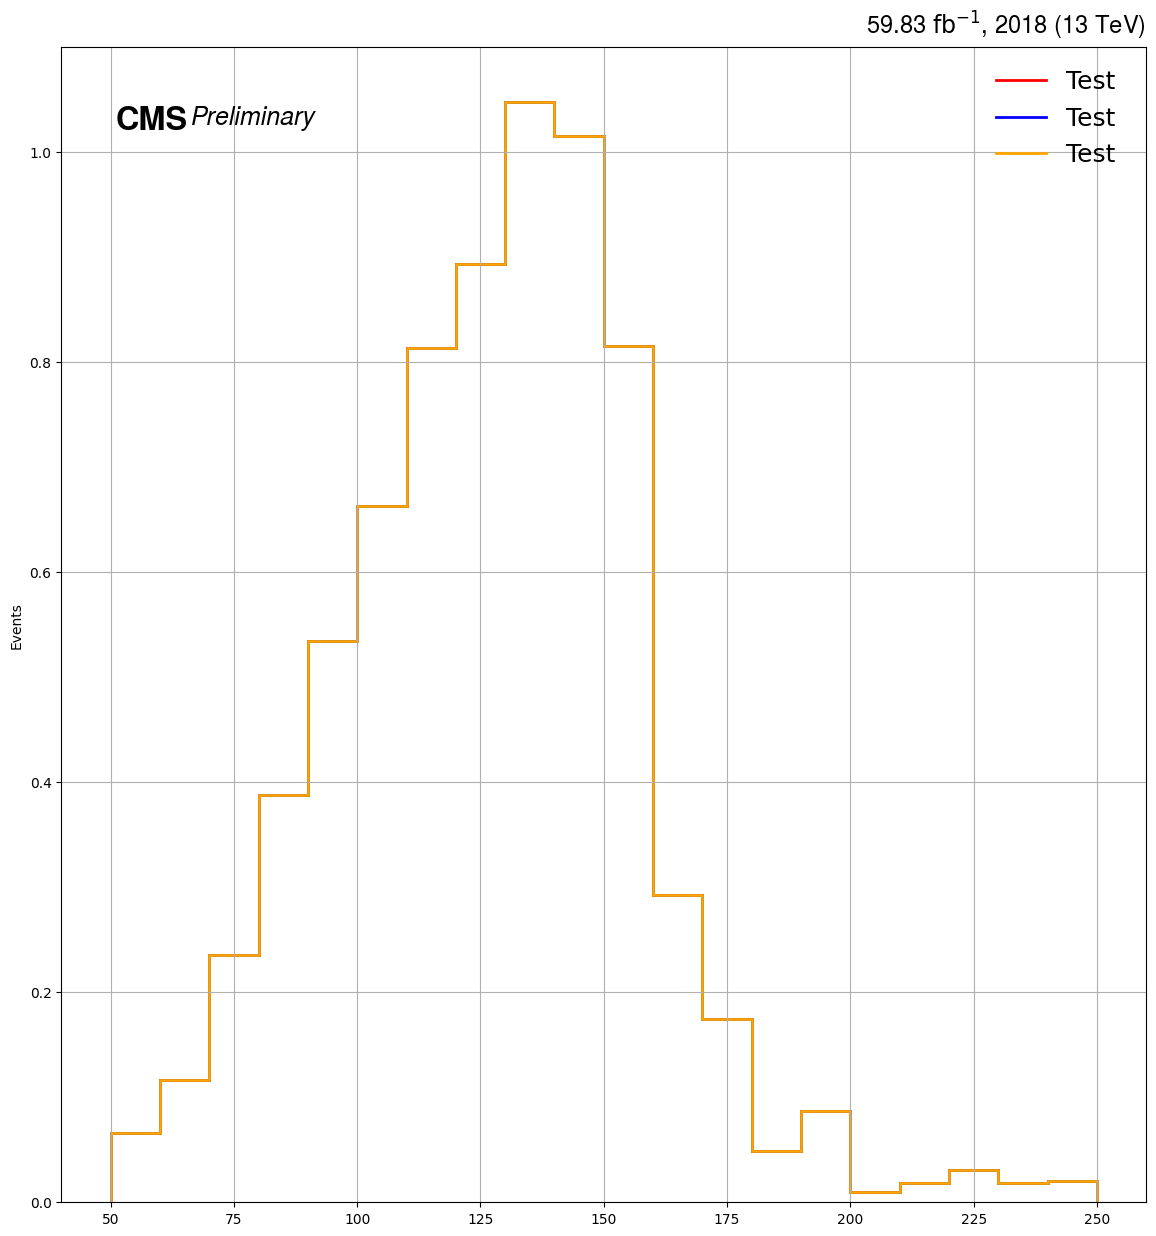

In [12]:
nbins, x_min, x_max = 20, 50, 250

plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])

f = plt.figure(figsize=(14, 15))
ax = f.add_subplot(1, 1, 1)  
ax.grid()

year = "2018"
LUMI = {"2016APV": 36.33,"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')

hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hep.histplot(get_template(hists_template1["SR1a"],"ggF_L1Prefiring_up")[0], bins=get_template(hists_template1["SR1a_JES_up"],"TT")[1], label="Test ", histtype='step', stack=False, linewidth=2, ax=ax,color = "red")

hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hep.histplot(get_template(hists_template1["SR1a"],"ggF")[0], bins=get_template(hists_template1["SR1a_JES_up"],"TT")[1], label="Test ", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")

hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hep.histplot(get_template(hists_template1["SR1a"],"ggF_L1Prefiring_down")[0], bins=get_template(hists_template1["SR1a_JES_up"],"TT")[1], label="Test ", histtype='step', stack=False, linewidth=2, ax=ax,color = "orange")


ax.set_ylabel("Events")
ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=18)
plt.show()

### Some other test

In [ ]:
regions = {
        "CR1" :{"SRa": "SR1a","SRb":"SR1b"},
        "CR2" :{"SRa": "SR2a","SRb":"SR2b"},
        "CR3" :{"SRa": "SR3a","SRb":"SR3b"},
        }

regions_blinded = { key_fail + "_blinded": {key_pass + "_blinded" : key_pass_ab + "_blinded" for key_pass , key_pass_ab in key_pass_dict.items()}  for key_fail , key_pass_dict in regions.items()}
regions_blinded.keys()

In [ ]:
region = "SR1a_blinded"
pass_region = ("a_" in region)
pass_region

In [ ]:
region = "SR1aBlinded"
region_noblinded = region.split("Blinded")[0]
region_noblinded

In [14]:
for files in os.listdir("./root/"):
    if not files.startswith("2017"):
        os.system(f"mv ./root/{files} ./root/2018_{files}")